In [1]:
import pandas
import lib.csse_covid_19_dataset.data_processing as data_processing

column_infected = 'Infected (confirmed)'
column_deceased = 'Deceased'
column_recovered = 'Recovered'

# get confirmed data
df_csse_covid_19_dataset_confirmed = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
                                                     infer_datetime_format=True, parse_dates=True)
df_confirmed_prep = data_processing.getCasesPerDayAndCountry(df_csse_covid_19_dataset_confirmed)
# add toplevel column header for confirmed
df_confirmed_prep.columns = pandas.MultiIndex.from_tuples(map(lambda x: (column_infected, x[0], x[1]), df_confirmed_prep.columns))
#print(df_confirmed_prep)

# get deaths data
df_csse_covid_19_dataset_deaths = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
                                           infer_datetime_format=True, parse_dates=True)
df_deaths_prep = data_processing.getCasesPerDayAndCountry(df_csse_covid_19_dataset_deaths)
# add toplevel column header for deceased
df_deaths_prep.columns = pandas.MultiIndex.from_tuples(map(lambda x: (column_deceased, x[0], x[1]), df_deaths_prep.columns))

# get recovered data
df_csse_covid_19_dataset_recovered = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv',
                                           infer_datetime_format=True, parse_dates=True)
df_recovered_prep = data_processing.getCasesPerDayAndCountry(df_csse_covid_19_dataset_recovered)
# add toplevel column header for recovered
df_recovered_prep.columns = pandas.MultiIndex.from_tuples(map(lambda x: (column_recovered, x[0], x[1]), df_recovered_prep.columns))

# get everything into one dataframe
df_prep = pandas.concat([df_confirmed_prep, df_deaths_prep, df_recovered_prep], axis=1)
#print(df_prep.columns.values)
#print(df_prep.describe)
#print(df_prep)


In [2]:
import data

df_prep.columns = df_prep.columns.swaplevel(0, 1)
df_prep.columns = df_prep.columns.swaplevel(1, 2)
#print(df_prep.columns.values)
# e.g. ('US', 'Ulster County, NY', 'Infected (confirmed)')
# Remove provinces and sum values from provinces
data_processing.dropProvinceIndex(df_prep)
#print(df_prep)
#print(df_prep.columns)
df_prep = df_prep.groupby(level=[0, 1], axis=1).sum()
#print(df_prep.columns)

df_at = data_processing.selectCountries(df_prep, [data.at])
df_at_neighbours = data_processing.selectCountries(df_prep, data.at_neighbours)
df_at_nationalities = data_processing.selectCountries(df_prep, data.at_nationalities)
df_at_travel_incomming = data_processing.selectCountries(df_prep, data.at_travel_incomming)
df_at_travel_outgoing = data_processing.selectCountries(df_prep, data.at_travel_outgoing)
#print(df_at)

In [3]:
future_days = 14
column_name = [data.at, column_infected]
prediction_infections_column_name = column_infected+' Prediction'

def prev_times1_4(prev_value, n):
    if not isinstance(prev_value, list):
        prev_value = [prev_value]
    if n == 0: return []
    if n == 1: return prev_value
    elif n == 2: return prev_value+[prev_value[-1] * 1.4]
    else: return prev_times1_4(prev_value+[prev_value[-1] * 1.4], n - 1)

#print(prev_times1_4(1,2))
#print(prev_times1_4(1,5))
#print(prev_times1_4(2,5))
# print(df_prep.loc[:, pandas.IndexSlice[:, :, [column_infected]]])

df_at_pred = data_processing.assignPredictionFromFirstInfectionUntilFuture(df_at, column_name, prediction_infections_column_name, future_days, prev_times1_4)
#print(df_at_pred)

/home/mario/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:1000: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  vi = tuple(self.axis.get_view_interval())
/home/mario/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  return ax.plot(*args, **kwds)
/home/mario/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  return ax.plot(*args, **kwds)
/home/mario/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  return ax.plot(*args, **kwds)
/home/mario/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  return ax.plot(*args, 

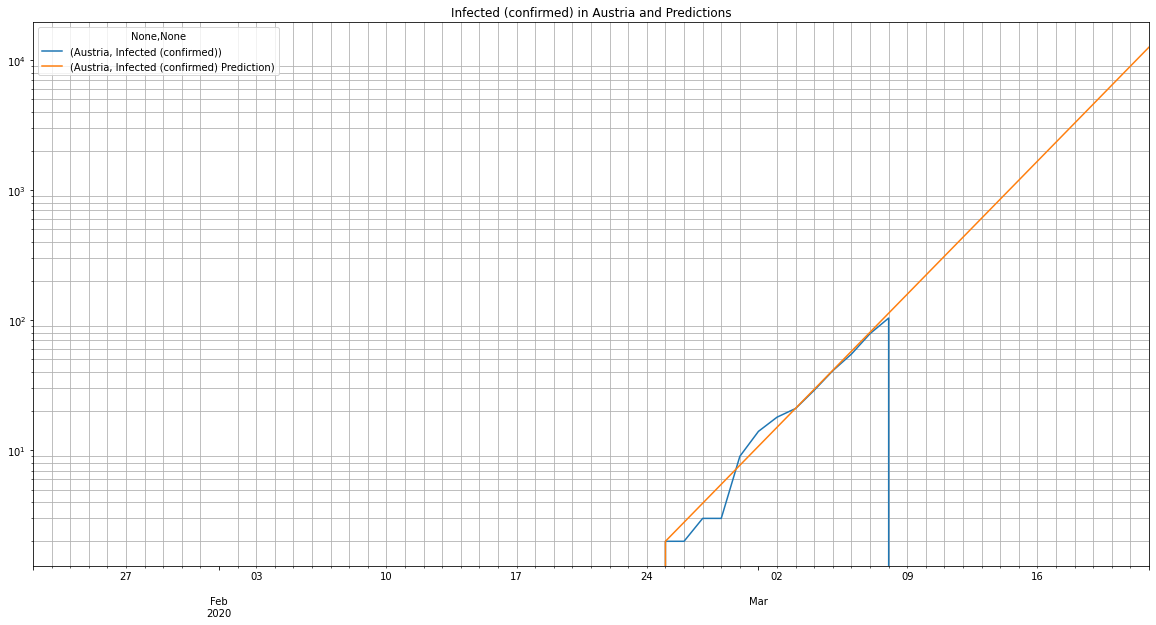

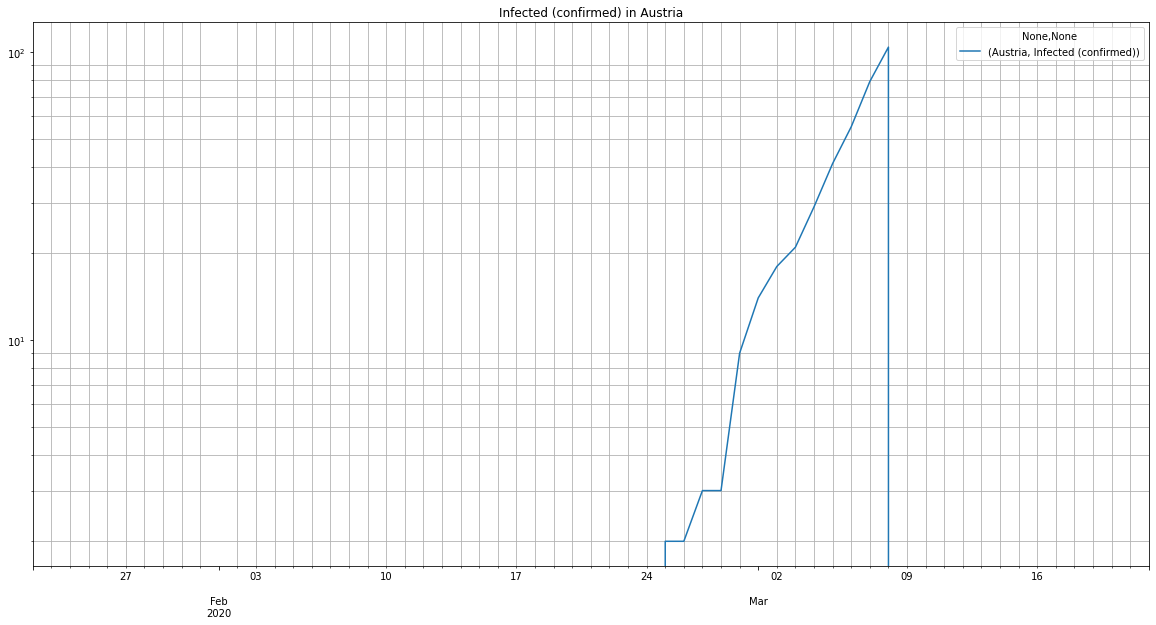

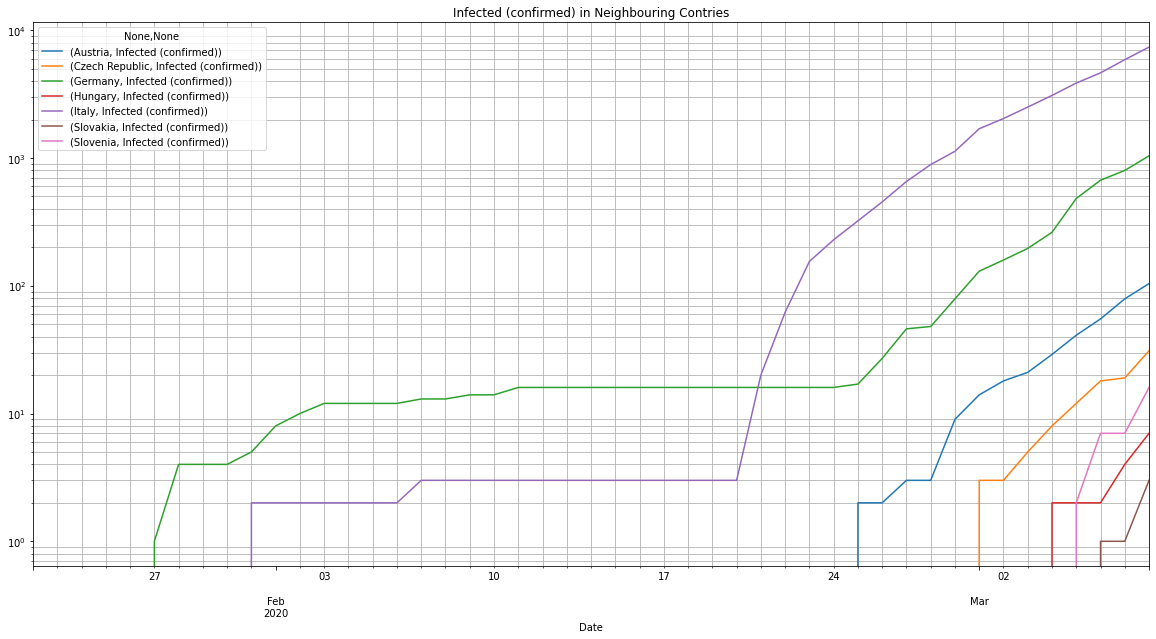

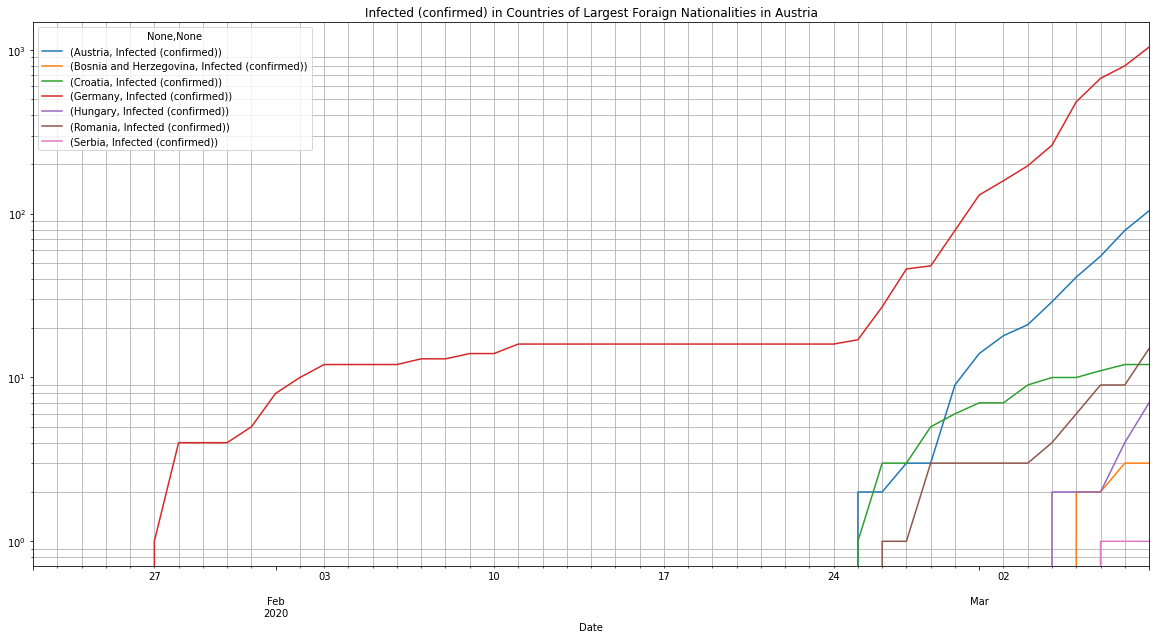

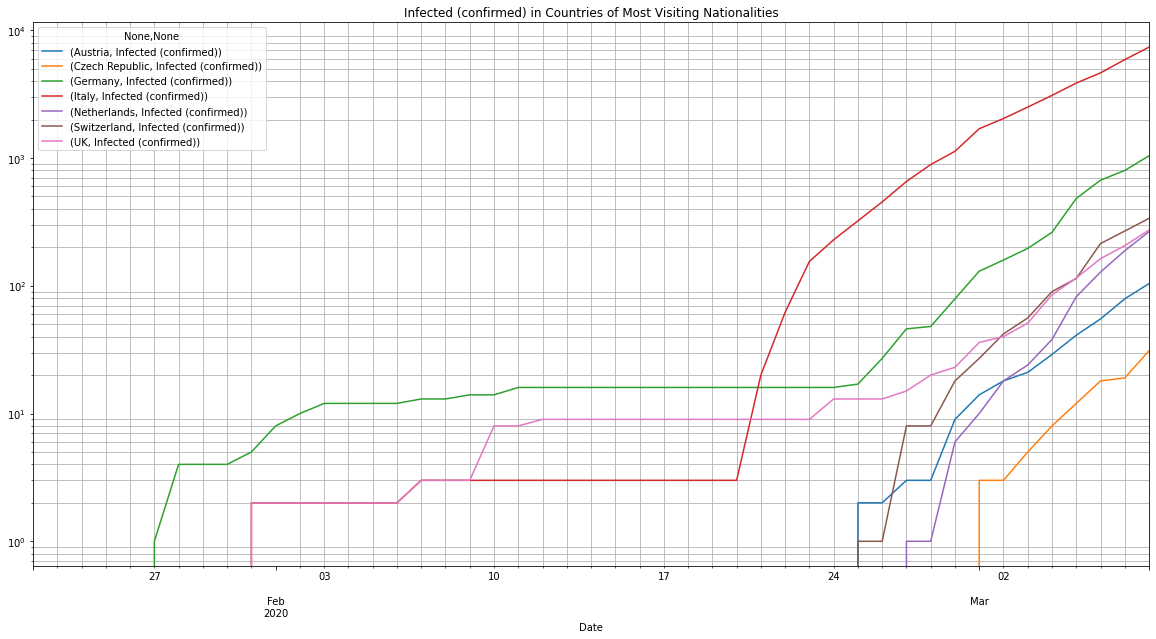

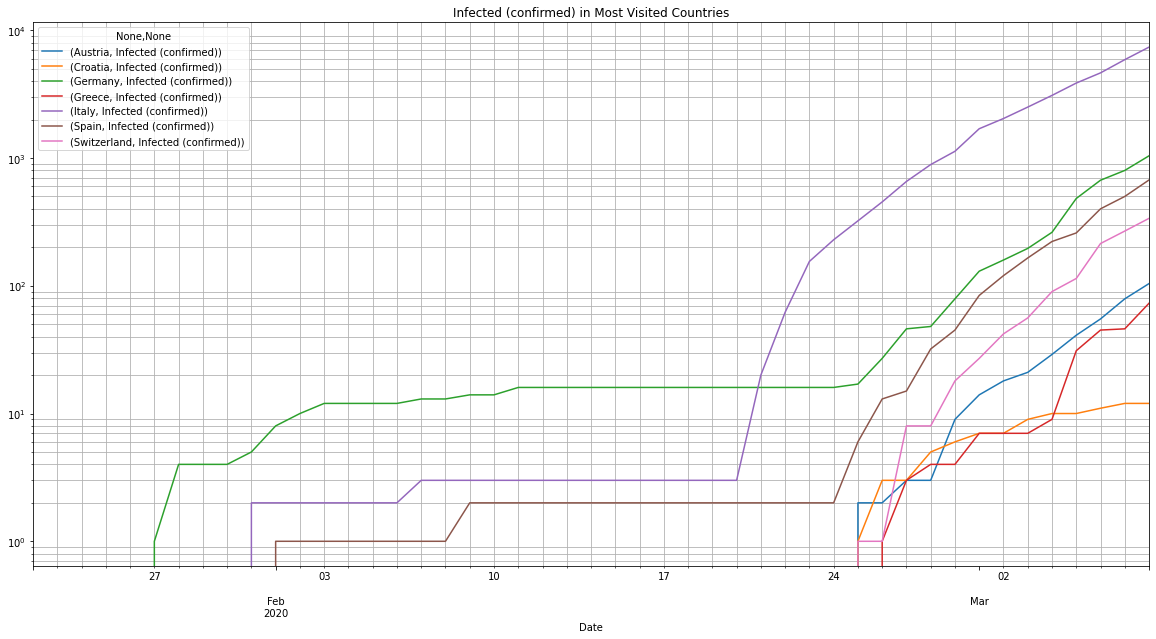

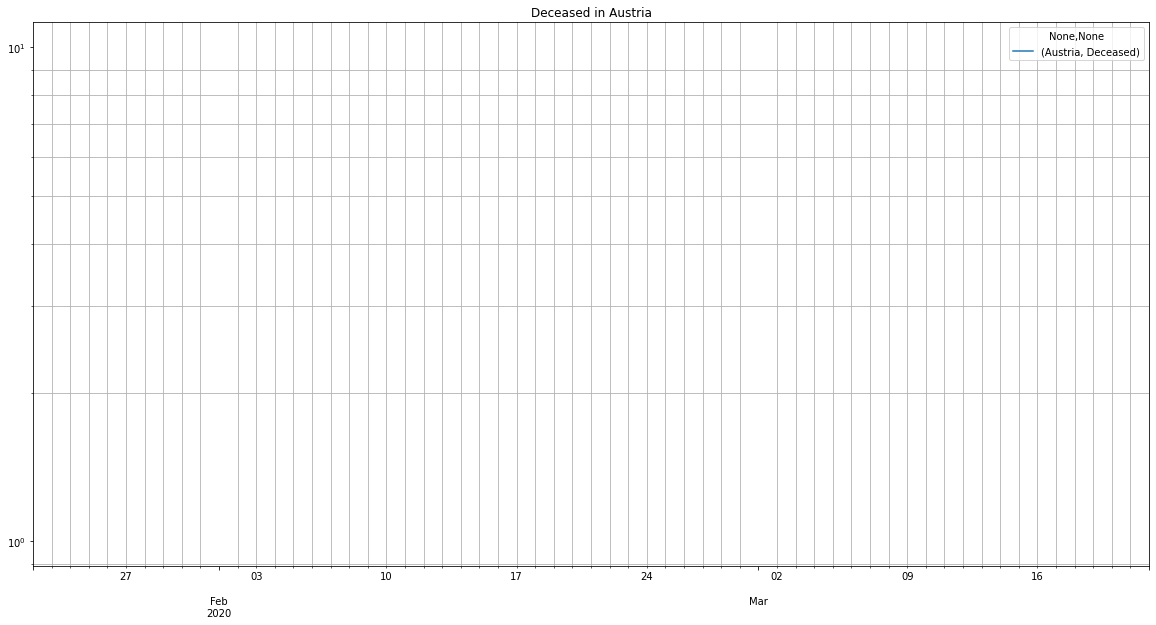

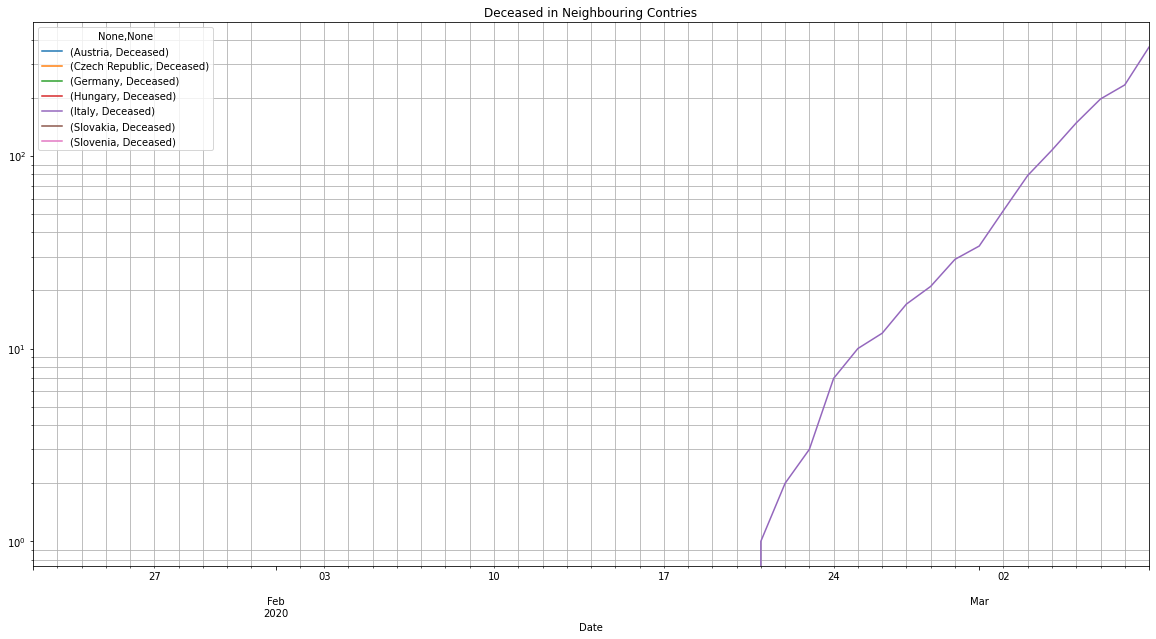

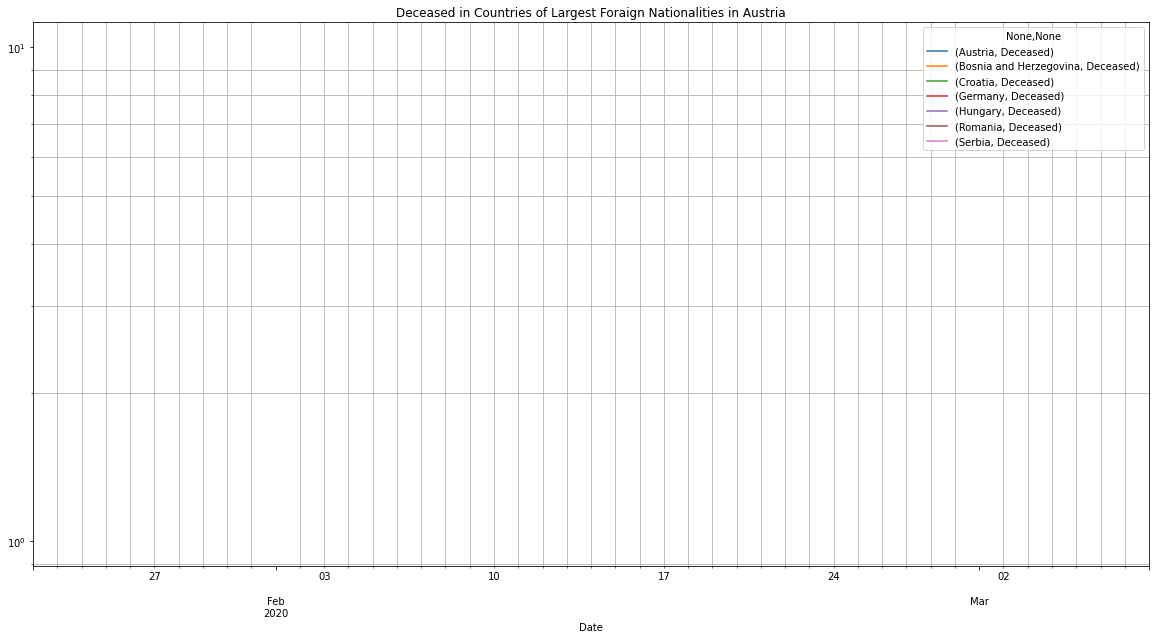

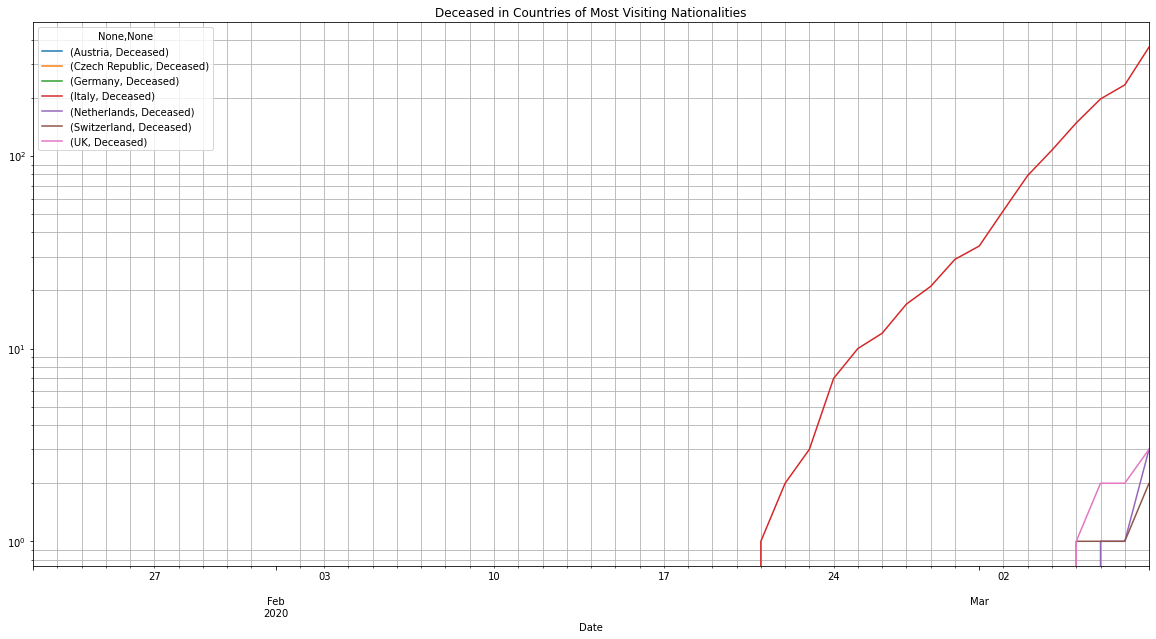

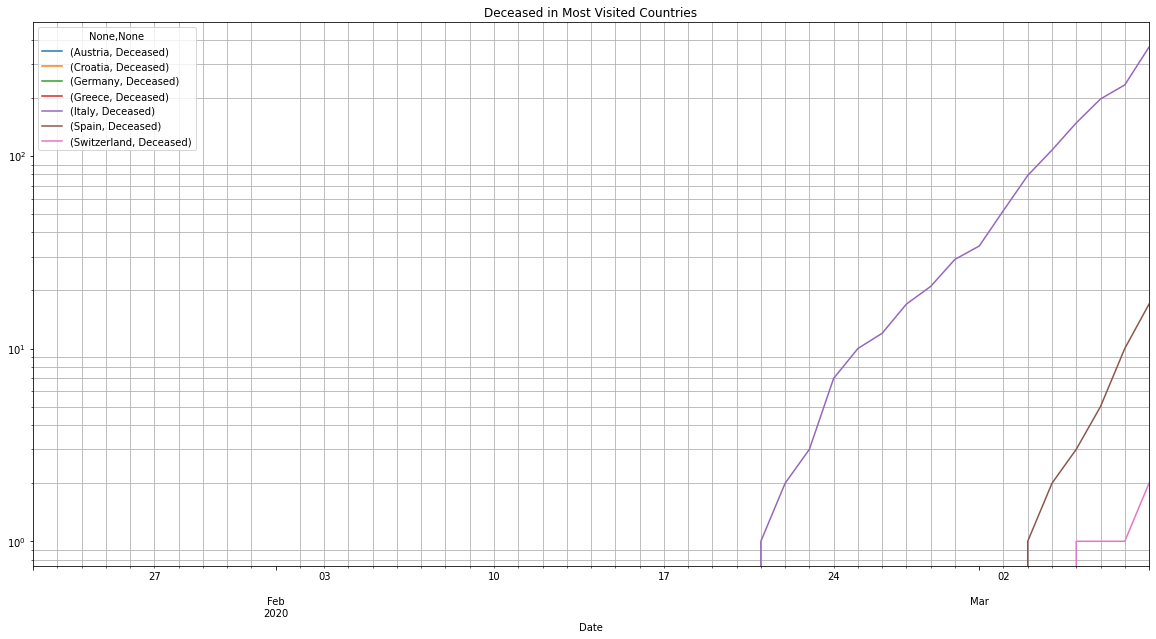

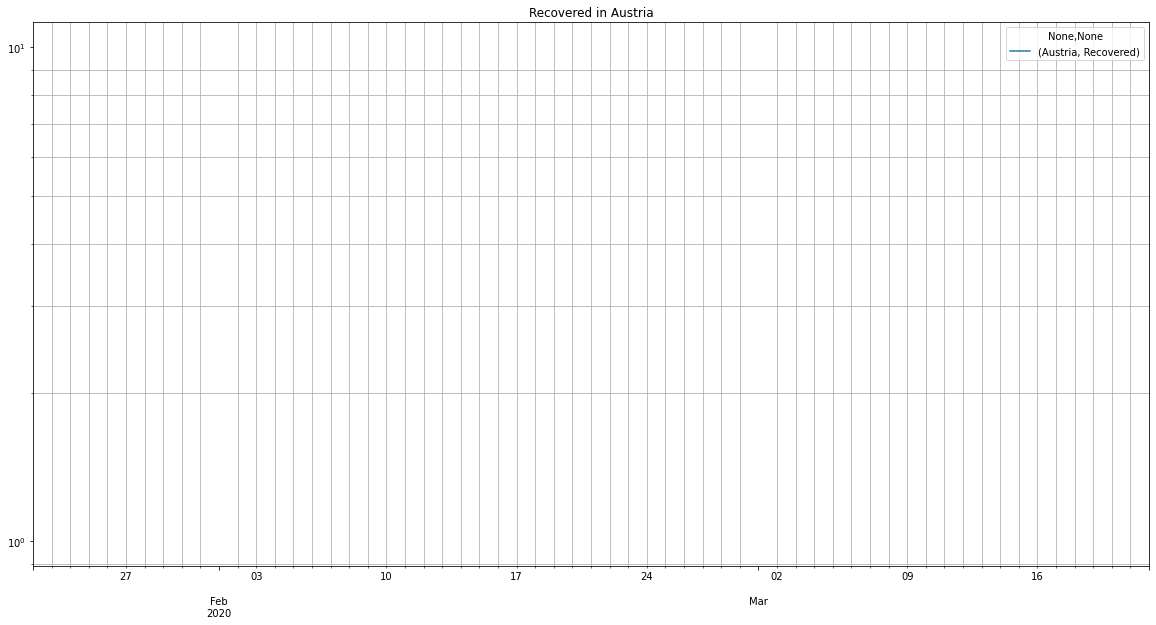

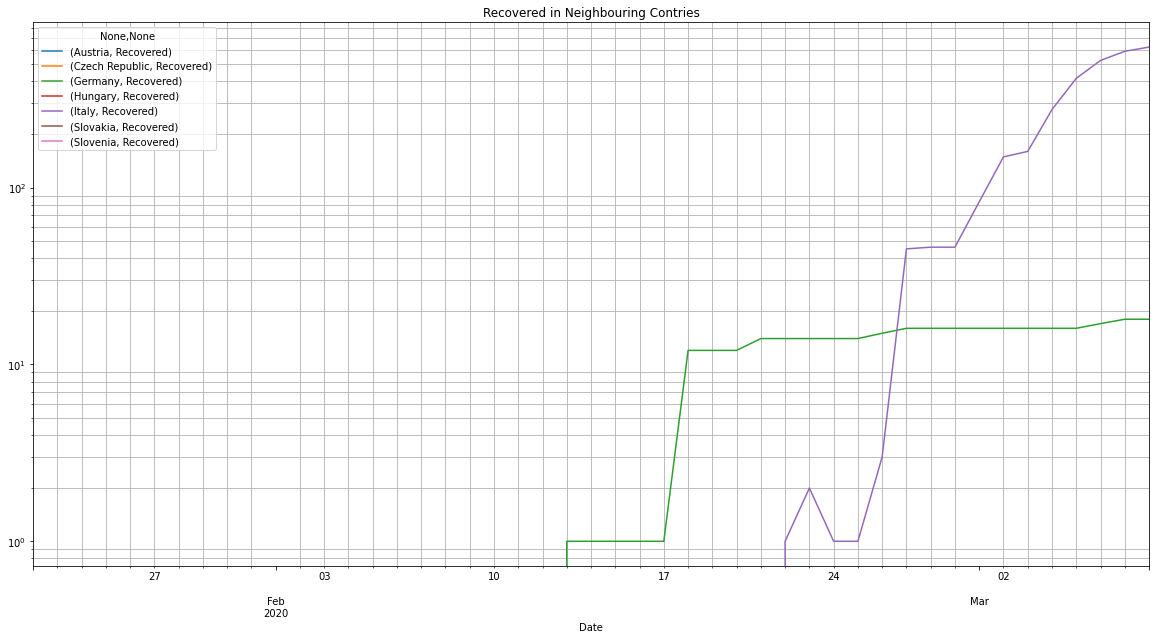

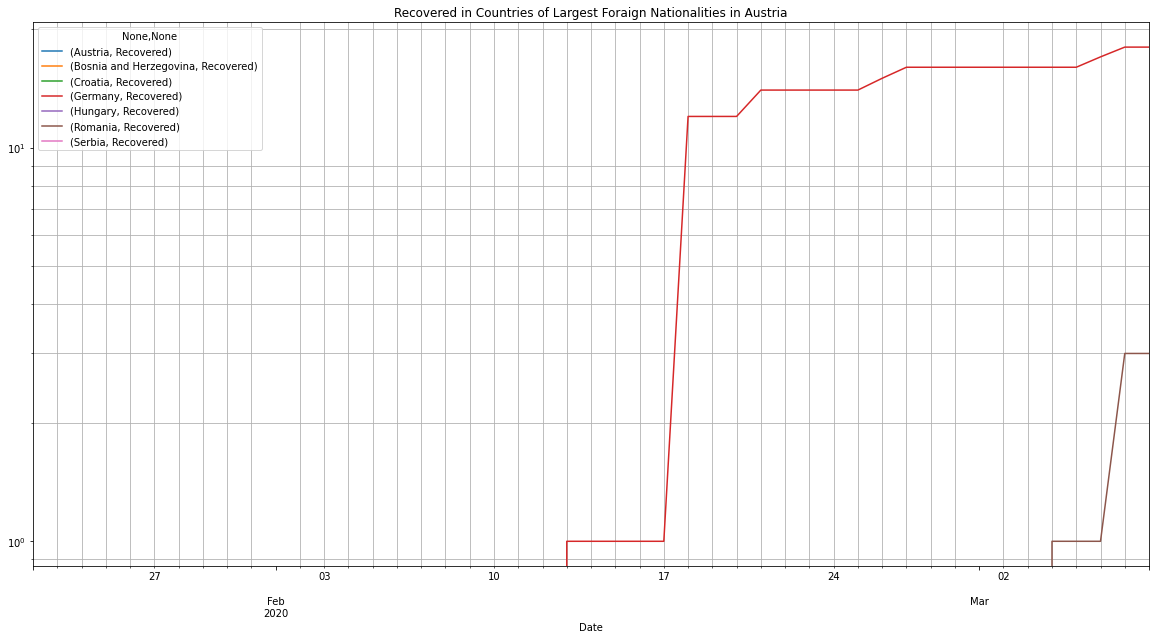

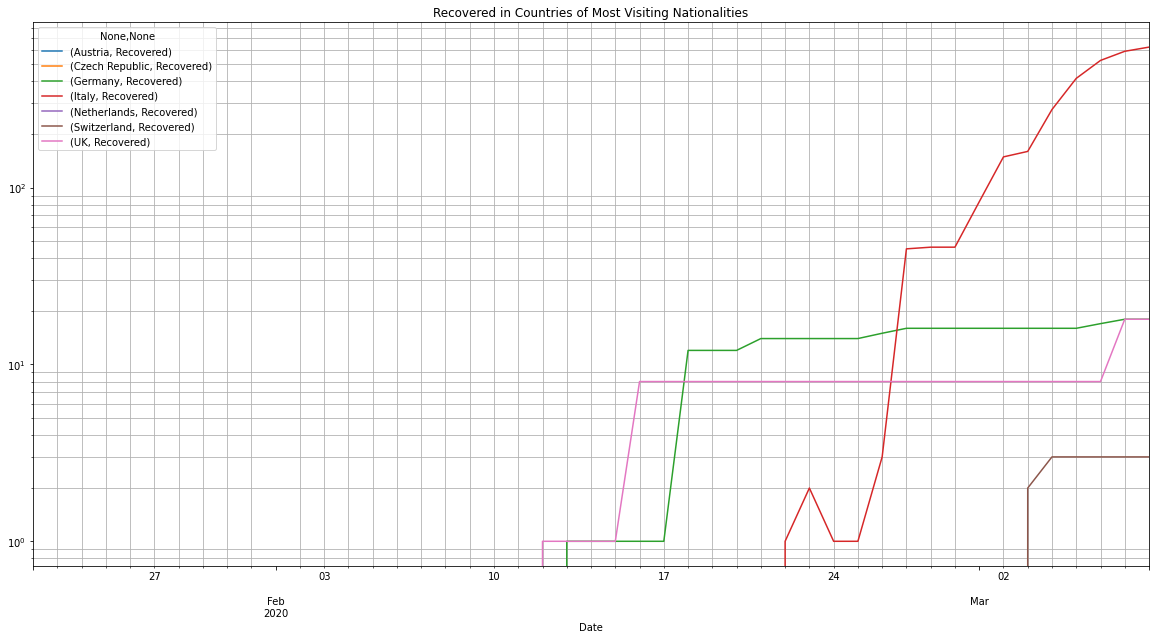

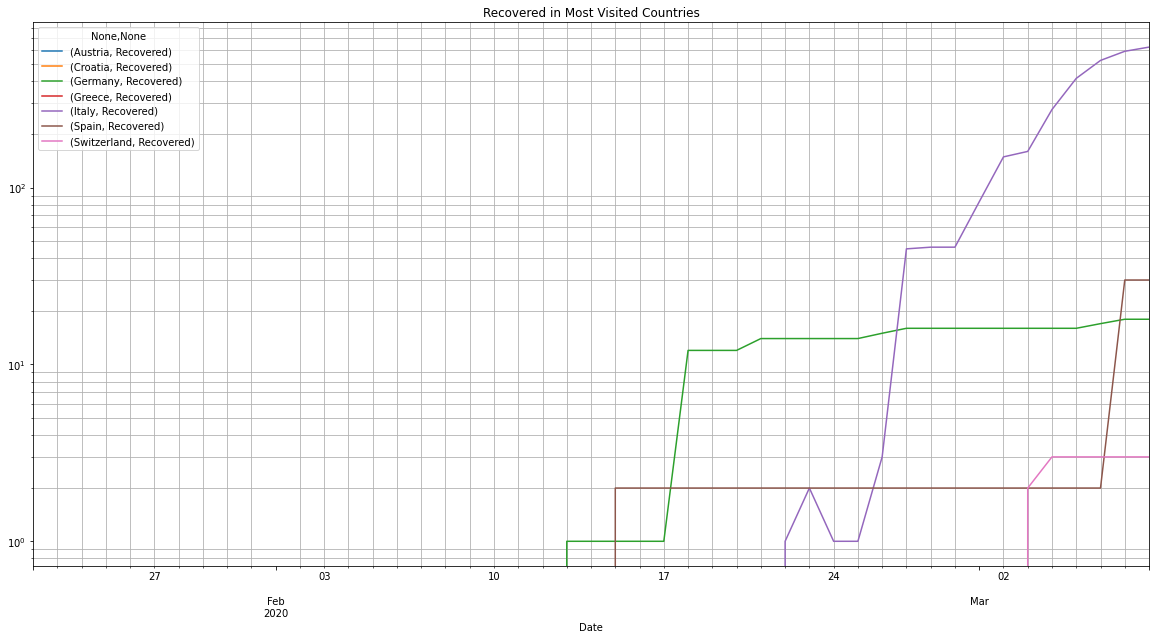

In [4]:
import lib.csse_covid_19_dataset.io as io
import os

latest_data_date = df_prep.index[-1].strftime("%Y-%m-%d")
    
directory = "export/{}/".format(latest_data_date)
if not os.path.exists(directory):
    os.makedirs(directory)

df_at_infected_pred_title = "{} in {} and Predictions".format(column_infected, data.at)
df_at_infected_pred = df_at_pred.loc[:, pandas.IndexSlice[:, [column_infected, prediction_infections_column_name]]]
io.saveDataCsv(df_at_infected_pred, directory, column_infected+"_"+df_at_infected_pred_title)
io.plotAndSavePng(df_at_infected_pred, df_at_infected_pred_title, (20, 10), True, directory, column_infected+"_"+df_at_infected_pred_title)

def displayAndSaveData(column, df_at, df_at_neighbours, df_at_nationalities, df_at_travel_incomming, df_at_travel_outgoing):
    df_at_title = "{} in {}".format(column, data.at)
    df_at_neighbours_title = "{} in Neighbouring Contries".format(column)
    df_at_nationalities_title = "{} in Countries of Largest Foraign Nationalities in {}".format(column, data.at)
    df_at_travel_incomming_title = "{} in Countries of Most Visiting Nationalities".format(column)
    df_at_travel_outgoing_title = "{} in Most Visited Countries".format(column)

    df_at = df_at_pred.loc[:, pandas.IndexSlice[:, [column]]]
    df_at_neighbours = df_at_neighbours.loc[:, pandas.IndexSlice[:, [column]]]
    df_at_nationalities = df_at_nationalities.loc[:, pandas.IndexSlice[:, [column]]]
    df_at_travel_incomming = df_at_travel_incomming.loc[:, pandas.IndexSlice[:, [column]]]
    df_at_travel_outgoing = df_at_travel_outgoing.loc[:, pandas.IndexSlice[:, [column]]]

    io.saveDataCsv(df_at, directory, column+"_"+df_at_title)
    io.saveDataCsv(df_at_neighbours, directory, column+"_"+df_at_neighbours_title)
    io.saveDataCsv(df_at_nationalities, directory, column+"_"+df_at_nationalities_title)
    io.saveDataCsv(df_at_travel_incomming, directory, column+"_"+df_at_travel_incomming_title)
    io.saveDataCsv(df_at_travel_outgoing, directory, column+"_"+df_at_travel_outgoing_title)

    io.plotAndSavePng(df_at, df_at_title, (20, 10), True, directory, column+"_"+df_at_title)
    io.plotAndSavePng(df_at_neighbours, df_at_neighbours_title, (20, 10), True, directory, column+"_"+df_at_neighbours_title)
    io.plotAndSavePng(df_at_nationalities, df_at_nationalities_title, (20, 10), True, directory, column+"_"+df_at_nationalities_title)
    io.plotAndSavePng(df_at_travel_incomming, df_at_travel_incomming_title, (20, 10), True, directory, column+"_"+df_at_travel_incomming_title)
    io.plotAndSavePng(df_at_travel_outgoing, df_at_travel_outgoing_title, (20, 10), True, directory, column+"_"+df_at_travel_outgoing_title)
    
displayAndSaveData(column_infected, df_at, df_at_neighbours, df_at_nationalities, df_at_travel_incomming, df_at_travel_outgoing)
displayAndSaveData(column_deceased, df_at, df_at_neighbours, df_at_nationalities, df_at_travel_incomming, df_at_travel_outgoing)
displayAndSaveData(column_recovered, df_at, df_at_neighbours, df_at_nationalities, df_at_travel_incomming, df_at_travel_outgoing)
